*import necessary libraries*

In [34]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the data

In [2]:
# import the preprocessing pipeline
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preproc_pipeline_script import preprocessing_pipeline

# import the data
data = pd.read_csv('data\clean_data\Musical_instruments_reviews_clean.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Apply the preprocessing

In [3]:
# apply the preprocessing pipeline
total = len(data)
for i in range(len(data)):
    #print(f'Processing {i+1}/{total}...')
    data['review'][i] = preprocessing_pipeline(data['review'][i])

Lets save the data into a new file for future use

In [4]:
# save the data in new file
data.to_csv('data/pre_proc_data/Musical_instruments_reviews_clean.csv', index=False)

# Convert text into vectors

As computer can't understand text, we need to convert text into vectors. We will use TF-IDF vectorizer for this purpose.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(min_df=0.0,max_df=1,use_idf=True,ngram_range=(1,2))

# fit and transform the data with TfidfVectorizer
tftest = tf.fit_transform(data['review'])

In [14]:
# now lets convert positive neutral and negative to 1, 0 and -1
data['sentiment'] = data['sentiment'].map({'Positive':1, 'Neutral':0, 'Negative':-1})

In [16]:
# lets count the number of positive and negative reviews
print(data['sentiment'].value_counts())

sentiment
 1    9015
 0     772
-1     467
Name: count, dtype: int64


In [15]:
# save the data in new file
data.to_csv('data/pre_proc_data/Musical_instruments_reviews_vector.csv', index=False)

The tf-idf will be implemented directly into the model class for better performance.

# Create the model class

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px

In [18]:
class_labels = ['Negative', 'Neutral', 'Positive']

confusion_matrix_kwargs = dict(
    text_auto=True, 
    title="Confusion Matrix", width=1000, height=800,
    labels=dict(x="Predicted", y="True Label"),
    x=class_labels,
    y=class_labels,
    color_continuous_scale='Blues'
)

class Model:
    def __init__(self, X, y, model_architecture, vectorizer, random_seed=42, test_size=0.2) -> None:
        self.X = X
        self.y = y
        self.model_instance = model_architecture
        self.vectorizer = vectorizer
        self.random_seed = random_seed
        self.test_size = test_size
        
        # the pipeline as defined previously
        self.pipeline = Pipeline([
            ('vectorizer', self.vectorizer),
            ('model', self.model_instance)
        ])

        # train test split using the above X, y, test_size and random_state
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_seed)
    
    def fit(self):
        # fit self.pipeline to the training data
        self.pipeline.fit(self.X_train, self.y_train)
        

    def predict(self):
        return self.pipeline.predict(self.X_test)

    def predict_custom(self, X_test):
        return self.pipeline.predict(X_test)
    
    def predict_proba(self):
        return self.pipeline.predict_proba(self.X_test)

        
    
    def report(self, y_true, y_pred, class_labels):
        print(classification_report(y_true, y_pred, target_names=class_labels))
        confusion_matrix_toshow = confusion_matrix(y_true, y_pred)
        fig = px.imshow(
            confusion_matrix_toshow, 
            **confusion_matrix_kwargs
            )
        fig.show()

Lets use the model class to train a simple model.

In [20]:
from sklearn.linear_model import LogisticRegression

In [30]:
X = data['review']
y = data['sentiment']

In [22]:
test_size=0.2 
random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [23]:
model = Model(X, y, LogisticRegression(), TfidfVectorizer(min_df=0.0,max_df=1,use_idf=True,ngram_range=(1,2)))
model.fit()

In [24]:
y_pred = model.predict()

In [25]:
model.report(y_test, y_pred, class_labels)

c:\Users\antoi\Anaconda3\envs\NPL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\antoi\Anaconda3\envs\NPL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\antoi\Anaconda3\envs\NPL\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       107
     Neutral       0.00      0.00      0.00       133
    Positive       0.88      1.00      0.94      1811

    accuracy                           0.88      2051
   macro avg       0.29      0.33      0.31      2051
weighted avg       0.78      0.88      0.83      2051



Those results are bad, but we will use this model as a baseline for future models.  
One of the main reasons for this bad performance is the imbalance of the dataset as there is a lot more positive reviews than negative ones.

In [29]:
test_data = pd.concat((X_test, y_test), axis=1)
test_data["pred"] = y_pred
# using np.where, create a variable equal to one when the encoded sentiment and model prediction match
# https://numpy.org/doc/stable/reference/generated/numpy.where.html
test_data["correct_prediction"] = np.where(test_data["sentiment"] == test_data["pred"], 1, 0)
test_data

,review,sentiment,pred,correct_prediction
119,hard love cord carries electrons way end sure ...,1,1,1
8771,dont know 39 top headstock bottom body know gu...,1,1,1
3609,bought strap use acoustic dreadnought guitar w...,0,1,0
1923,tough unit easy set locks tight materials robu...,1,1,1
3064,cheap easy use cuts sound 70 ideal beginner li...,1,1,1
...,...,...,...,...
3881,stand surprised lightweight still sturdy would...,1,1,1
1328,handy multiple benefits useful loosen screw ho...,1,1,1
4418,ability quickly change range sensitivity made ...,1,1,1
2889,favorite string back 60s guitar shop great str...,1,1,1


As we can see the model is overfitting, we will try to fix this in the next notebook.

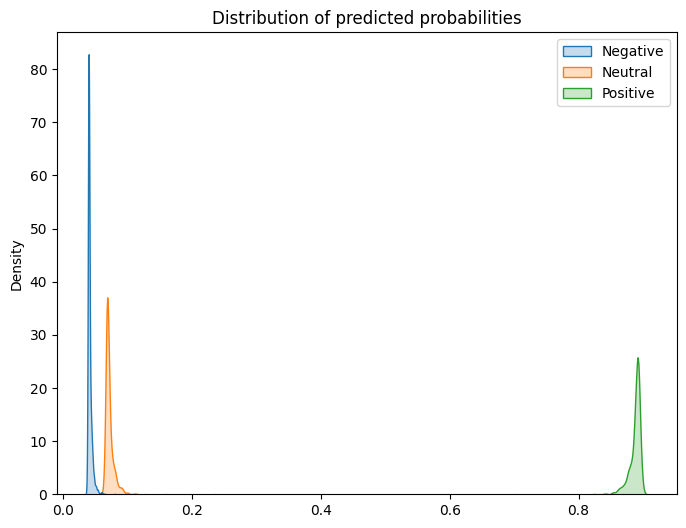

In [35]:
probas = pd.DataFrame(model.predict_proba(), columns=class_labels)
plt.figure(figsize=(8,6))
sns.kdeplot(data=probas, fill=True, )
plt.title("Distribution of predicted probabilities")
plt.show()